In [2]:
import pystac_client
import os
import boto3
from obstore.store import S3Store
from obstore.auth.boto3 import Boto3CredentialProvider
from virtualizarr.registry import ObjectStoreRegistry
from obstore.store import S3Store
from virtualizarr import open_virtual_dataset
from virtual_tiff import VirtualTIFF
import xarray as xr
import pyproj
import xproj
import rasterix
import logging
import morecantile
import shapely
from shapely.ops import transform
from pyproj import Transformer
from shapely import wkt
import pystac
from rasterio.warp import transform_bounds
from affine import Affine
from rasterix import RasterIndex
from pyresample.area_config import create_area_def
from rasterio.transform import array_bounds
from pyresample.gradient import block_nn_interpolator, gradient_resampler_indices_block
from pyresample.resampler import resample_blocks
import folium

In [3]:
# Connect to Earth Search STAC API
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

california_bbox = [-124.4096, 32.5343, -114.1312, 42.0095]

search = catalog.search(
    collections=["landsat-c2-l2"],  # Landsat Collection 2 Level-2
    bbox=california_bbox,
    datetime="2025-10-01/2025-10-10",
    max_items=10
)

items = list(search.items())
item = items[0]
item

<Item id=LC09_L2SP_045034_20251009_02_T2>

In [4]:
def generate_geoproj(item: pystac.Item):
    projected_bbox = transform_bounds(
        "EPSG:4326",
        item.properties["proj:code"],
        *item.bbox
    )
    geo_proj_extension = {
        "version": "0.1.0",
        "schema": "https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json",
        "name": "geo:proj",
        "description": "Coordinate reference system information for geospatial data",
        "spec": "https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md",
        "configuration": {
            "code": item.properties["proj:code"],
            "spatial_dimensions": ["y", "x"],
            "transform": item.properties["proj:transform"],
            "shape": item.properties["proj:shape"],
            "bbox": projected_bbox,
        }
    }
    return geo_proj_extension

In [5]:
geo_proj = generate_geoproj(item=item)
geo_proj

{'version': '0.1.0',
 'schema': 'https://raw.githubusercontent.com/zarr-experimental/geo-proj/refs/tags/v0.1.0/schema.json',
 'name': 'geo:proj',
 'description': 'Coordinate reference system information for geospatial data',
 'spec': 'https://github.com/zarr-experimental/geo-proj/blob/v0.1.0/README.md',
 'configuration': {'code': 'EPSG:32610',
  'spatial_dimensions': ['y', 'x'],
  'transform': [30, 0, 323385, 0, -30, 4265415],
  'shape': [7871, 7751],
  'bbox': (318509.86282391835,
   4027575.057273871,
   557421.3350006378,
   4266891.820921776)}}

In [6]:
scheme = "s3://"
bucket = "usgs-landsat"
region = "us-west-2"

In [7]:
profile = "impactnew"
os.environ["AWS_PROFILE"] = profile

In [8]:
session = boto3.Session()
object_store = S3Store(
    bucket=bucket,
    region=region,
    request_payer=True,
    credential_provider=Boto3CredentialProvider(session=session),
)
registry = ObjectStoreRegistry({f"{scheme}{bucket}": object_store})

In [9]:
asset = item.assets["red"]
parser=VirtualTIFF(ifd=0)
manifest_store = parser(url=asset.href, registry=registry)
ds = xr.open_dataset(manifest_store, engine="zarr", consolidated=False, zarr_format=3)
ds

/Users/seanharkins/projects/zarr-datafusion-examples/.venv/lib/python3.13/site-packages/numcodecs/zarr3.py:164: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/Users/seanharkins/projects/zarr-datafusion-examples/.venv/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:139: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 122MB
Dimensions:  (y: 7871, x: 7751)
Dimensions without coordinates: y, x
Data variables:
    0        (y, x) uint16 122MB ...

In [10]:
affine = Affine(*geo_proj["configuration"]["transform"])
index = RasterIndex.from_transform(
    affine=affine,
    width=geo_proj["configuration"]["shape"][1],
    height=geo_proj["configuration"]["shape"][0],
    x_dim="x",
    y_dim="y",
    crs=geo_proj["configuration"]["code"],
)
coords = xr.Coordinates.from_xindex(index)
ds = ds.assign_coords(coords)
ds

<xarray.Dataset> Size: 122MB
Dimensions:  (y: 7871, x: 7751)
Coordinates:
  * y        (y) float64 63kB 4.265e+06 4.265e+06 ... 4.029e+06 4.029e+06
  * x        (x) float64 62kB 3.234e+05 3.234e+05 ... 5.559e+05 5.559e+05
Data variables:
    0        (y, x) uint16 122MB ...
Indexes:
  ┌ x        RasterIndex (crs=EPSG:32610)
  └ y

In [11]:
ds = ds.proj.assign_crs(spatial_ref=item.properties["proj:code"])
ds

<xarray.Dataset> Size: 122MB
Dimensions:      (y: 7871, x: 7751)
Coordinates:
  * y            (y) float64 63kB 4.265e+06 4.265e+06 ... 4.029e+06 4.029e+06
  * x            (x) float64 62kB 3.234e+05 3.234e+05 ... 5.559e+05 5.559e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 122MB ...
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32610)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32610)

In [12]:
granule_bbox = morecantile.commons.BoundingBox(*item.bbox)
tms = morecantile.tms.get("WebMercatorQuad")
tiles = list(tms.tiles(*granule_bbox, zooms=7))
tiles

[Tile(x=19, y=49, z=7),
 Tile(x=20, y=49, z=7),
 Tile(x=19, y=50, z=7),
 Tile(x=20, y=50, z=7)]

In [13]:
tile_bbox = tms.xy_bounds(tiles[0])
tile_bbox_geom = shapely.geometry.box(*tile_bbox)
utm_transformer = Transformer.from_crs("EPSG:3857", item.properties["proj:code"], always_xy=True).transform
tile_bbox_utm = transform(utm_transformer, tile_bbox_geom)
tile_bbox_utm.bounds

(181301.5722617702, 4050528.187131678, 434893.91588177846, 4303122.059170065)

In [14]:
left, bottom, right, top = tile_bbox_utm.bounds
ds_tile = ds.sel(x=slice(left, right), y=slice(top, bottom))
ds_tile

<xarray.Dataset> Size: 53MB
Dimensions:      (y: 7162, x: 3716)
Coordinates:
  * y            (y) float64 57kB 4.265e+06 4.265e+06 ... 4.051e+06 4.051e+06
  * x            (x) float64 30kB 3.234e+05 3.234e+05 ... 4.348e+05 4.348e+05
  * spatial_ref  int64 8B 0
Data variables:
    0            (y, x) uint16 53MB ...
Indexes:
  ┌ x            RasterIndex (crs=EPSG:32610)
  └ y
    spatial_ref  CRSIndex (crs=EPSG:32610)

In [15]:
tile_shape = 512
height, width = geo_proj["configuration"]["shape"]
left, bottom, right, top = array_bounds(height, width, affine)
#left = ds_tile["0"].x.min()
#bottom = ds_tile["0"].y.min()
#right = ds_tile["0"].x.max()
#top = ds_tile["0"].y.max()
target_area_def = create_area_def(
    area_id=1,
    projection="EPSG:3857",
    shape=(tile_shape, tile_shape),
    area_extent=tile_bbox_geom.bounds
)

source_area_def = create_area_def(
    area_id=2,
    projection=geo_proj["configuration"]["code"],
    shape=(geo_proj["configuration"]["shape"][0], geo_proj["configuration"]["shape"][1]),
    area_extent=geo_proj["configuration"]["bbox"],
)

In [16]:
da = ds_tile["0"].chunk(chunks="auto")
indices_xy = resample_blocks(
    gradient_resampler_indices_block,
    source_area_def,
    [],
    target_area_def,
    chunk_size=(1, tile_shape, tile_shape),
    dtype=float,
)
resampled = resample_blocks(
    block_nn_interpolator,
    source_area_def,
    [da.data],
    target_area_def,
    dst_arrays=[indices_xy],
    chunk_size=(1, tile_shape, tile_shape),
    dtype=ds_tile["0"].dtype,
)
projected_tile = resampled.compute()

In [17]:
da = xr.DataArray(projected_tile, dims=("y", "x"))
da

<xarray.DataArray (y: 512, x: 512)> Size: 524kB
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 35671, 28954, 31073],
       [    0,     0,     0, ..., 31933, 36412, 20180],
       [    0,     0,     0, ..., 13085, 14098, 29652]],
      shape=(512, 512), dtype=uint16)
Dimensions without coordinates: y, x

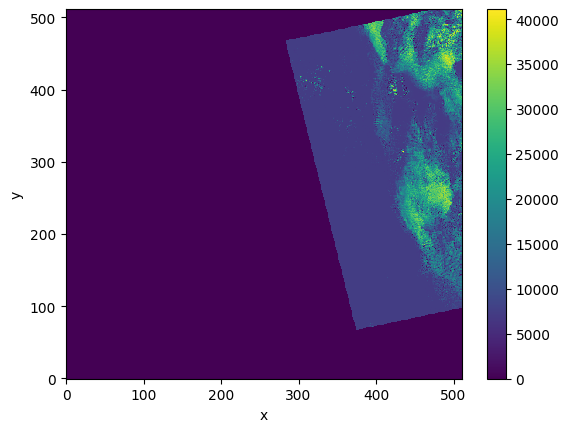

In [18]:
da.plot()